# Implémentation du modèle ARIMA

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
register_matplotlib_converters()

In [2]:
df = pd.read_csv("/Users/victorhuynh/Downloads/database_sieges.csv", parse_dates = ['Date'], index_col = ['Date'])

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


On va s'intéresser à la variable "PAX" : c'est cette dernière qu'on va prédire avec le modèle ARIMA

In [3]:
df1 = df[['PAX']] #On ne garde que la variable PAX
df1 = df1.groupby('Date').agg({'PAX':'mean'})
rolling_mean = df1.rolling(window = 12).mean()
rolling_std = df1.rolling(window = 12).std()

In [20]:
df1['PAX'].sort_values().head()

Date
2009-01-29    82.431767
2011-02-01    83.840557
2012-12-04    83.926829
2008-12-02    84.935681
2009-03-04    85.382540
Name: PAX, dtype: float64

On a deux valeurs aberrantes, nulles ou quasi-nulles : il s'agit du 2010-04-18 et 2010-04-19, dates où les vols étaient impossibles dû à l'éruption d'un volcan en Islande. Retirons-les, sinon par la suite en appliquant le log, on obtient des valeurs infinies problématiques : 

In [21]:
df1 = df1.drop([pd.to_datetime('2010-04-18'),pd.to_datetime('2010-04-19')])

KeyError: "[Timestamp('2010-04-18 00:00:00') Timestamp('2010-04-19 00:00:00')] not found in axis"

In [22]:
#result = seasonal_decompose(df1['PAX'],  
#                            model ='multiplicative',
#                            freq=1) 
#result.plot()

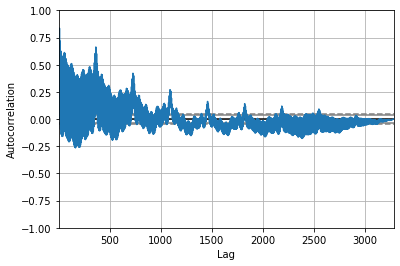

In [23]:
autocorrelation_plot(df1)
plt.show()

Observons les tendances de PAX, sa moyenne mobile et son écart-type mobile : 

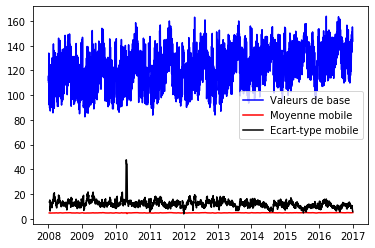

In [24]:
plt.plot(df1, color = 'blue', label = 'Valeurs de base')
plt.legend(loc = 'best')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.legend(loc = 'best')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')

La fonction suivante nous renvoie des informations nous permettant de juger si une série est stationnaire ou non : 

In [25]:
def get_stationarity(timeseries):
    
    # Statistiques mobiles
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # tracé statistiques mobiles
    original = plt.plot(timeseries, color='blue', label='Valeurs de base')
    mean = plt.plot(rolling_mean, color='red', label='Moyenne Mobile')
    std = plt.plot(rolling_std, color='black', label='Ecart-type Mobile')
    plt.legend(loc='best')
    plt.title('Moyenne et écart-type Mobiles')
    plt.show(block=False)
    
    # Test Dickey–Fuller :
    result = adfuller(timeseries['PAX'])
    print('Statistiques ADF : {}'.format(result[0]))
    print('p-value : {}'.format(result[1]))
    print('Valeurs Critiques :')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

Pour réduire les variations, on peut passer au log :

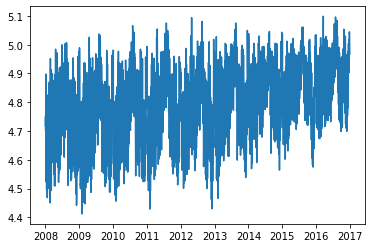

In [26]:
df_log = np.log(df1)
plt.plot(df_log)

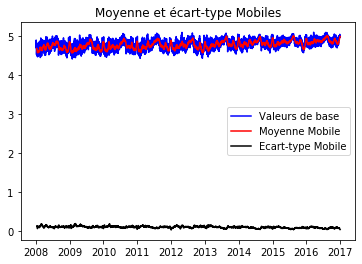

Statistiques ADF : -5.709403911790183
p-value : 7.358995352546913e-07
Valeurs Critiques :
	1%: -3.432359970177518
	5%: -2.862428084811229
	10%: -2.5672427465340872


In [27]:
get_stationarity(df_log)

Pour stationnariser, on peut soustraire la moyenne mobile : 

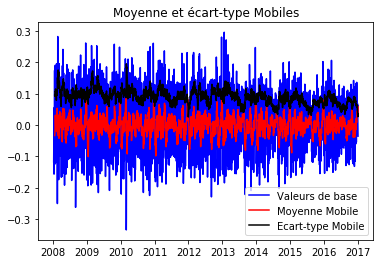

Statistiques ADF : -13.328609491343324
p-value : 6.24840237539321e-25
Valeurs Critiques :
	1%: -3.43236616722938
	5%: -2.8624308219885193
	10%: -2.567244203750082


In [28]:
rolling_mean = df_log.rolling(window=10).mean()
df_log_minus_mean = df_log - rolling_mean
get_stationarity(df_log_minus_mean.dropna())

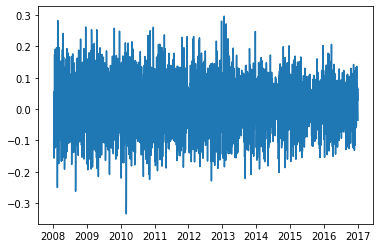

In [29]:
plt.plot(df_log_minus_mean)

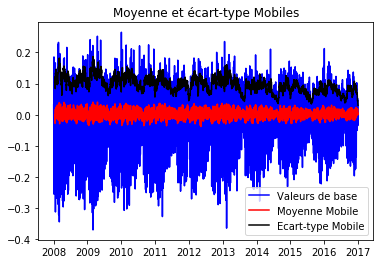

Statistiques ADF : -14.94870488537204
p-value : 1.2899833457361125e-27
Valeurs Critiques :
	1%: -3.432359970177518
	5%: -2.862428084811229
	10%: -2.5672427465340872


In [30]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

plot_pacf(df_log_shift['PAX'])
plot_acf(df_log_shift['PAX'])

Trouvons les paramètres les plus appropriés pour notre modèle ARIMA :

In [5]:
!pip install pmdarima 
from pmdarima import auto_arima

In [33]:
stepwise_fit = auto_arima(df_log['PAX'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=29.96 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=-2370.754, Time=1.39 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-4250.096, Time=24.95 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=26.51 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=-2372.608, Time=0.51 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=-3752.068, Time=1.62 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-6037.118, Time=39.42 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=64.99 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=31.09 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=-4716.185, Time=24.16 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=-6137.811, Time=41.23 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=-5722.387, Time=11.17 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=68.25 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=41.47 sec
 ARIMA(3,0,0)(2,1,0)[12] inter

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 3285
Model:             SARIMAX(2, 0, 3)x(1, 1, [1], 12)   Log Likelihood                3897.577
Date:                              Sun, 21 Mar 2021   AIC                          -7777.155
Time:                                      21:00:22   BIC                          -7722.313
Sample:                                           0   HQIC                         -7757.516
                                             - 3285                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      1.696      0.090   -6.96e-05       0.001
ar.L1          1.2204      0.004    289.419      0.000       1.212       1.229
ar.L2         -0.9721      0.004   -245.565      0.000      -0.980      -0.964
ma.L1         -0.5380      0.016    -32.712      0.000      -0.570      -0.506
ma.L2          0.3919      0.018     21.728      0.000       0.357       0.427
ma.L3          0.4986      0.017     29.881      0.000       0.466       0.531
ar.S.L12       0.1552      0.024      6.564      0.000       0.109       0.202
ma.S.L12      -0.8643      0.014    -59.705      0.000      -0.893      -0.836
sigma2         0.0054      0.000     44.376      0.000       0.005       0.006
===================================================================================
Ljung-Box (L1) (Q):                  35.92   Jarque-Bera (JB):               139.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
stepwise_fit = auto_arima(df_log['PAX'], 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3285
Model:               SARIMAX(5, 1, 4)   Log Likelihood                4929.853
Date:                Sun, 21 Mar 2021   AIC                          -9839.707
Time:                        21:07:36   BIC                          -9778.739
Sample:                             0   HQIC                         -9817.877
                               - 3285                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3636      0.018     20.462      0.000       0.329       0.398
ar.L2         -1.0755      0.015    -70.689      0.000      -1.105      -1.046
ar.L3          0.1516      0.026      5.890      0.000       0.101       0.202
ar.L4         -0.6344      0.014    -45.322      0.000      -0.662      -0.607
ar.L5         -0.4354      0.017    -26.196      0.000      -0.468      -0.403
ma.L1         -0.7086      0.015    -46.519      0.000      -0.738      -0.679
ma.L2          1.1448      0.016     69.981      0.000       1.113       1.177
ma.L3         -0.6851      0.017    -39.627      0.000      -0.719      -0.651
ma.L4          0.6852      0.014     50.318      0.000       0.659       0.712
sigma2         0.0029   5.34e-05     54.587      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   5.16   Jarque-Bera (JB):               597.48
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECA

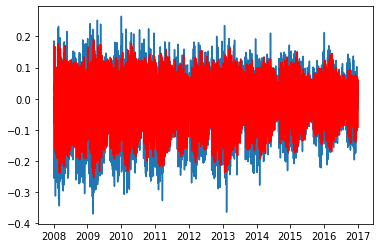

In [36]:
decomposed = seasonal_decompose(df_log, freq=1)
model = ARIMA(df_log, order=(5,1,4))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')

Retour aux valeurs normales :

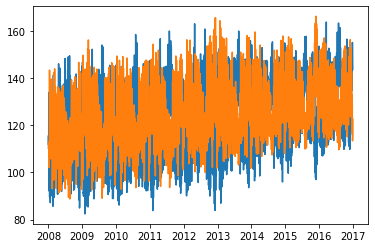

In [38]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['PAX'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df1)
plt.plot(predictions_ARIMA)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


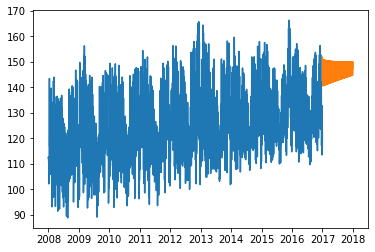

In [39]:
index_future_dates=pd.date_range(start='2016-12-31',end='2017-12-31')
#print(index_future_dates)
prediction=results.predict(start=len(df_log),end=len(df_log)+365,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
prediction.index=index_future_dates

plt.plot(predictions_ARIMA)
plt.plot(np.exp(prediction))

In [97]:
predictions_ARIMA_log

Date
2008-01-01    4.719327
2008-01-02    4.719392
2008-01-03    4.728385
2008-01-04    4.699251
2008-01-05    4.695703
                ...   
2016-12-27    4.868341
2016-12-28    4.836050
2016-12-29    4.822291
2016-12-30    4.835949
2016-12-31    4.868925
Length: 3285, dtype: float64

In [ ]:
#df_log.index = pd.DatetimeIndex(df_log.index).to_period('D')
#pd.to_datetime(df_log.index, format='%Y%m%d')

In [1]:
forecast = results.predict(start = pd.to_datetime('2016-12-31'), end =pd.to_datetime('2017-12-31'),typ='levels')
  
# Plot the forecast values 
#df_log['PAX'].plot(figsize = (12, 5), legend = True) 
forecast.plot(legend = True) 

NameError: name 'results' is not defined

In [ ]:
fig = results.plot_predict(1, 2100)

In [ ]:
df1

In [ ]:
from statsmodels import get_prediction
pred = results.get_prediction(start=pd.to_datetime('2016-12-31'), dynamic=False)
pred_ci = pred.conf_int()

In [19]:
print(df_log.shape)
train=df_log.iloc[:-300]
test=df_log.iloc[-300:]
print(train.shape,test.shape)

(3285, 1)
(2985, 1) (300, 1)


In [34]:
stepwise_fit = auto_arima(df_log['PAX'], 
                          suppress_warnings=True)           

stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3285
Model:               SARIMAX(5, 1, 4)   Log Likelihood                4929.853
Date:                Sun, 21 Mar 2021   AIC                          -9839.707
Time:                        21:05:51   BIC                          -9778.739
Sample:                             0   HQIC                         -9817.877
                               - 3285                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3636      0.018     20.462      0.000       0.329       0.398
ar.L2         -1.0755      0.015    -70.689      0.000      -1.105      -1.046
ar.L3          0.1516      0.026      5.890      0.000       0.101       0.202
ar.L4         -0.6344      0.014    -45.322      0.000      -0.662      -0.607
ar.L5         -0.4354      0.017    -26.196      0.000      -0.468      -0.403
ma.L1         -0.7086      0.015    -46.519      0.000      -0.738      -0.679
ma.L2          1.1448      0.016     69.981      0.000       1.113       1.177
ma.L3         -0.6851      0.017    -39.627      0.000      -0.719      -0.651
ma.L4          0.6852      0.014     50.318      0.000       0.659       0.712
sigma2         0.0029   5.34e-05     54.587      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   5.16   Jarque-Bera (JB):               597.48
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [2]:
model=ARIMA(train['PAX'],order=(5,1,4))
model=model.fit()
model.summary()

NameError: name 'ARIMA' is not defined

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


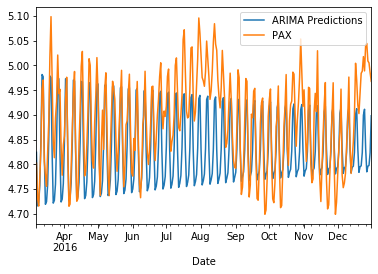

In [39]:
start=len(train)
end=len(train)+len(test)-1
pred1=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
index_dates_test=pd.date_range(start='2016-03-07',end='2016-12-31')
pred1.index=index_dates_test
pred1.plot(legend=True)
test['PAX'].plot(legend=True)

In [26]:
model2=ARIMA(df_log['PAX'],order=(1,0,5))
model2=model2.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,Unnamed: 0,Faisceau,Pays,Ville,Terrain,Terminal,Aerog,Aerop,Code Aerop,Cie,...,NumVol,TypAv,MVT,PAX,Date Equiv,MVT_FQM,PAX_FQM,Coeff_Rempl_FQM,Sièges Corrections_ICI,Coeff_Rempl
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-16,0,National,FRANCE,Bordeaux Merignac,ORLY,ORYW,ORYO,Bordeaux Merignac,LFBD,AIR FRANCE,...,AFR6272,321,1,150,NaN,NaN,NaN,NaN,203.635683,0.736610
2008-01-16,1,International,ALGERIE,Alger Houari Boumediene,ORLY,ORYS,ORYS,Alger Houari Boumediene,DAAG,AIGLE AZUR,...,AAF258,321,1,114,NaN,NaN,NaN,NaN,203.635683,0.559823
2008-01-27,2,National,FRANCE,Toulouse Blagnac,ORLY,ORYW,ORYO,Toulouse Blagnac,LFBO,AIR FRANCE,...,AFR6123,319,1,89,NaN,NaN,NaN,NaN,139.561067,0.637714
2008-08-24,3,International,TUNISIE,Monastir Skanes,ORLY,ORYS,ORYS,Monastir Skanes,DTMB,TRANSAVIA.COM,...,TVF1187,73H,1,186,NaN,NaN,NaN,NaN,188.563462,0.986405
2008-07-03,4,Schengen,ESPAGNE,Seville,ORLY,ORYW,ORYO,Seville,LEZL,AIR EUROPA,...,AEA1235,738,1,151,NaN,NaN,NaN,NaN,176.363083,0.856188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30,2078041,International,ALGERIE,Annaba Les Salines,ORLY,ORYS,ORYS,Annaba Les Salines,DABB,AIR ALGERIE,...,DAH1115,73H,1,113,2011-12-30,1.0,102.06,0.63,188.563462,0.599268
2016-12-31,2078042,Dom Tom,FRANCE GUADELOUPE,Pointe à Pitre Le Raizet,ORLY,ORYW,ORYO,Pointe à Pitre Le Raizet,TFFR,AIR FRANCE,...,AFR792,77W,1,389,2015-12-31,1.0,283.20,0.60,472.000000,0.824153
2016-12-30,2078043,National,FRANCE,Biarritz,ORLY,ORYW,ORYO,Biarritz,LFBZ,AIR FRANCE,...,AFR7487,319,1,145,2015-01-02,1.0,142.40,0.80,139.561067,1.038972


In [29]:
df_log

,PAX
Date,
2008-01-01,4.719327
2008-01-02,4.750648
2008-01-03,4.700612
2008-01-04,4.712444
2008-01-05,4.897724
...,...
2016-12-27,5.044515
2016-12-28,5.009132
2016-12-29,5.005201


In [40]:
index_future_dates=pd.date_range(start='2016-12-31',end='2017-01-30')
#print(index_future_dates)
pred2=model2.predict(start=len(df_log),end=len(df_log)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred2.index=index_future_dates
print(pred2)

2016-12-31    4.955014
2017-01-01    4.978396
2017-01-02    4.995043
2017-01-03    4.972420
2017-01-04    4.949800
2017-01-05    4.937998
2017-01-06    4.927023
2017-01-07    4.916818
2017-01-08    4.907329
2017-01-09    4.898505
2017-01-10    4.890299
2017-01-11    4.882669
2017-01-12    4.875574
2017-01-13    4.868976
2017-01-14    4.862841
2017-01-15    4.857137
2017-01-16    4.851832
2017-01-17    4.846899
2017-01-18    4.842312
2017-01-19    4.838047
2017-01-20    4.834081
2017-01-21    4.830392
2017-01-22    4.826963
2017-01-23    4.823774
2017-01-24    4.820809
2017-01-25    4.818051
2017-01-26    4.815487
2017-01-27    4.813103
2017-01-28    4.810885
2017-01-29    4.808824
2017-01-30    4.806907
Freq: D, Name: ARIMA Predictions, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


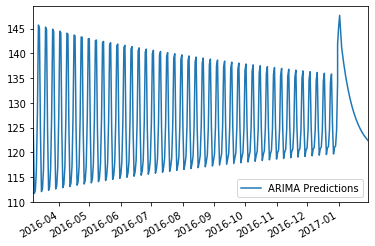

In [47]:
pred = pred1.append(pred2)
pred = np.exp(pred)
pred.plot(legend=True)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


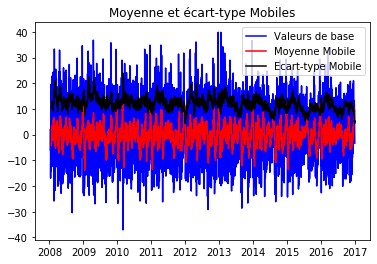

Statistiques ADF : -13.366326758454962
p-value : 5.3044478293271795e-25
Valeurs Critiques :
	1%: -3.4323674112281393
	5%: -2.8624313714499374
	10%: -2.5672444962719756


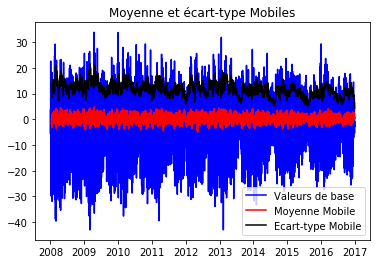

Statistiques ADF : -14.856322544557965
p-value : 1.7461490877350685e-27
Valeurs Critiques :
	1%: -3.432359970177518
	5%: -2.862428084811229
	10%: -2.5672427465340872


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency

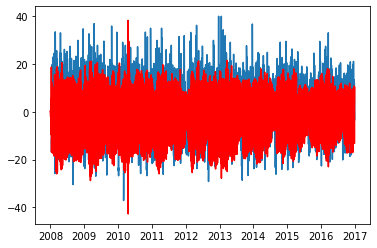

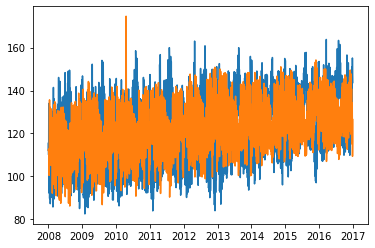

In [50]:
variable = 'PAX'
df = pd.read_csv("/Users/victorhuynh/Downloads/database_sieges.csv", parse_dates = ['Date'], index_col = ['Date'])
df = df[~(df.index.isin([pd.to_datetime('2010-04-18'),pd.to_datetime('2010-04-19')]))] 
#Retrait de ces deux dates où les données sont nulles (car incident volcanique)
    
df1 = df[[variable]]
df1 = df1.groupby('Date').agg({variable:'mean'})
#On retire ces deux dates où le trafic est nul

rolling_mean = df1.rolling(window=12).mean()
df_log_minus_mean = df1 - rolling_mean
#Pour stationnariser
get_stationarity(df_log_minus_mean.dropna())

df_log_shift = df1 - df1.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

#ARIMA en action
model = ARIMA(df_log, order=(5,1,4))
results = model.fit(disp=-1)
plot1 = plt.figure(1)
plt.plot(df_log_minus_mean)
plt.plot(results.fittedvalues, color='red')
#On compare prédiction et réalité

#Pour comparer à la série de base : il faut effectuer diverses opérations, dont le renversement de la différentiation et le passage à exp
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA = pd.Series(df1['PAX'].iloc[0], index=df_log.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff_cumsum, fill_value=0)
plot2 = plt.figure(2)
plt.plot(df1)
plt.plot(predictions_ARIMA)

In [47]:
df1['PAX'].sort_values()

Date
2010-04-18      0.000000
2010-04-19      2.000000
2009-01-29     82.431767
2011-02-01     83.840557
2012-12-04     83.926829
                 ...    
2012-08-18    160.848168
2016-08-13    161.501524
2012-04-28    163.061837
2016-07-30    163.387584
2016-03-20    163.826667
Name: PAX, Length: 3287, dtype: float64

# Cross-validation :

In [80]:
df = pd.read_csv("/Users/victorhuynh/Downloads/database_sieges.csv", parse_dates = ['Date'], index_col = ['Date'])
df1 = df[['PAX']] #On ne garde que la variable PAX
df1 = df1.groupby('Date').agg({'PAX':'mean'})
df1 = df1.drop([pd.to_datetime('2010-04-18'),pd.to_datetime('2010-04-19')])

pourcent_train = 0.70
point_sep = round(len(df1) * pourcent_train)
train, test = df1.iloc[:point_sep], df1.iloc[point_sep:]
train_diff = train.diff(periods = 1).dropna()

In [ ]:
stepwise_fit = auto_arima(train['PAX'], 
                          suppress_warnings=True)           

stepwise_fit.summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


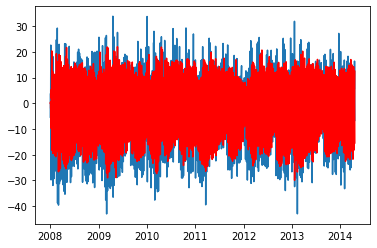

In [81]:
model = ARIMA(train, order=(5,1,4))
model_fit = model.fit(disp= -1)
plot1 = plt.figure(1)
plt.plot(train_diff)
plt.plot(results.fittedvalues, color='red')

prediction, se, conf = model_fit.forecast(len(test), alpha=0.05)
# On construit un intervalle de confiance à 95%
prediction_serie = pd.Series(prediction, index=test.index)
sup_conf = pd.Series(conf[:, 0], index=test.index)
inf_conf = pd.Series(conf[:, 1], index=test.index)

In [83]:
prediction_serie

Date
2014-04-22    126.058443
2014-04-23    129.906512
2014-04-24    132.120764
2014-04-25    138.925082
2014-04-26    151.331799
                 ...    
2016-12-27    142.912170
2016-12-28    145.365497
2016-12-29    145.075392
2016-12-30    143.280816
2016-12-31    145.890029
Length: 985, dtype: float64

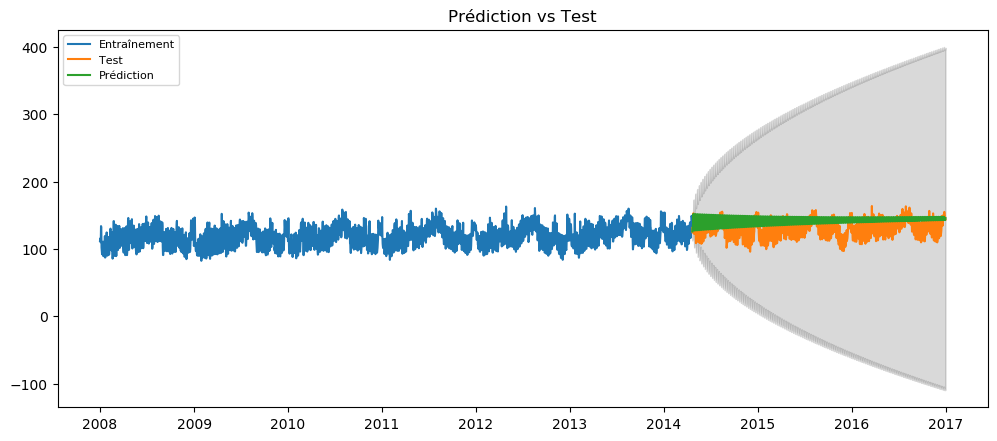

In [82]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='Entraînement')
plt.plot(test, label='Test')
plt.plot(prediction_serie, label='Prédiction')
plt.fill_between(inf_conf.index, inf_conf, sup_conf, 
                 color='k', alpha=.15)
plt.title('Prédiction vs Test')
plt.legend(loc='upper left', fontsize=8)
plt.show()